## Basic Configurations

In [1]:
# Import necessary modules for data analysis and visualisation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re

In [2]:
# Configure Seaborn styles
sns.set(style='whitegrid',palette='muted',color_codes=True)    

## Import Data

In [3]:
# Read files
patient = pd.read_csv('./data/sim_av_patient.csv', delimiter=',')
sact_patient = pd.read_csv('./data/sim_sact_patient.csv', delimiter=',')
tumour = pd.read_csv('./data/sim_av_tumour.csv', delimiter=',')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (5,6,8,9,17,18,20,22,26,32) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


ICD 10

In [4]:
# ICD10 Code
icd_codes = pd.read_csv('icd_codes.csv', delimiter=",", header=None, names=['Category Code', 'Diagnosis Code', 'Full Code', 'Abbreviated Description', 'Full Description', 'Category Title'])
icd_codes_3char = pd.read_csv('icd_codes_3char.csv', delimiter=",", header=None, names=['Code', 'Description'])
# icd_codes[icd_codes['Category Code'] == 'C449']

In [5]:
# Have a glance at the table
patient.head()

,PATIENTID,SEX,LINKNUMBER,ETHNICITY,DEATHCAUSECODE_1A,DEATHCAUSECODE_1B,DEATHCAUSECODE_1C,DEATHCAUSECODE_2,DEATHCAUSECODE_UNDERLYING,DEATHLOCATIONCODE,NEWVITALSTATUS,VITALSTATUSDATE
0,10000001,2,810000001,A,NaN,NaN,NaN,NaN,NaN,NaN,A,2017-01-17
1,10000002,2,810000002,Z,NaN,NaN,NaN,NaN,NaN,NaN,A,2017-01-14
2,10000003,1,810000003,A,NaN,NaN,NaN,NaN,NaN,NaN,A,2017-01-17
3,10000004,1,810000004,A,NaN,NaN,NaN,NaN,NaN,NaN,A,2017-01-13
4,10000005,2,810000005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A,2017-01-16


## About this table
This table contains 12 columns, which are about the synthetic patients' demographic information and vital status, as well as death cause of those who are deceased. The columns are:
- Patient ID
- Sex
- Link Number (allows linkeage to another table)
- Ethnicity
- Death Cause Code * 5 (1A, 1B, 1C, 2, Underlying)
- Death Location Code
- Vital Status
- Vital Status Date

There are 1,322,100 entries in this table.

In [6]:
patient.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1322100 entries, 0 to 1322099
Data columns (total 12 columns):
PATIENTID                    1322100 non-null int64
SEX                          1322100 non-null int64
LINKNUMBER                   1322100 non-null int64
ETHNICITY                    1192249 non-null object
DEATHCAUSECODE_1A            330280 non-null object
DEATHCAUSECODE_1B            98085 non-null object
DEATHCAUSECODE_1C            18106 non-null object
DEATHCAUSECODE_2             141982 non-null object
DEATHCAUSECODE_UNDERLYING    327910 non-null object
DEATHLOCATIONCODE            330381 non-null object
NEWVITALSTATUS               1322100 non-null object
VITALSTATUSDATE              1322100 non-null object
dtypes: int64(3), object(9)
memory usage: 121.0+ MB


## Data Cleaning

### Inconsistent delimiters in death cause code columns
There are several columns in this table which represent death causes of the patients. These death causes are recorded with ICD-10 codes and if a patient died because multiple factors, their codes are separated by commas.

However, in some of the rows, the delimiter is space(' '), semicolon(';'), or full-stop('.') rather than comma, which should be fixed. In the following cell, I used a function `to_comma` to do the replacement.

In [7]:
# Define a function which is used to turn all other delimiters in death cause code columns with commas.
def to_comma(code):
    if type(code) == str:
        if code.count('.') > 0 and any(x.isdigit() for x in code): # Replace full-stops with commas.
            code = code.replace('.', ',')
            return code
        elif code.count(';') > 0 and any(x.isdigit() for x in code):  # Replace semicolons with commas.
            code = code.replace(';', ',')
            return code
        elif code.count(' ') > 0 and any(x.isdigit() for x in code):   # Replace space with commas.
            code = code.replace(' ', ',')
            return code
      
        else:
            return code
    else:
        return code
    
    
# Apply the function to all the death cause code columns with `Series.map()`.
patient['DEATHCAUSECODE_1A'] = patient['DEATHCAUSECODE_1A'].map(to_comma)
patient['DEATHCAUSECODE_1B'] = patient['DEATHCAUSECODE_1B'].map(to_comma)
patient['DEATHCAUSECODE_1C'] = patient['DEATHCAUSECODE_1C'].map(to_comma)
patient['DEATHCAUSECODE_2'] = patient['DEATHCAUSECODE_2'].map(to_comma)
patient['DEATHCAUSECODE_UNDERLYING'] = patient['DEATHCAUSECODE_UNDERLYING'].map(to_comma)

After converting all the inconsistent delimiters, I tried to split all the cells containing multiple death causes and calculate how many times a death cause code showed in this table, this is to see:
1. If all the delimiters were correctly turned into commas.
2. If there was any other value that was not recoreded in ICD-10 codes.

In [8]:
death_causes = {} # Init a dict to store all the death cause codes and how many times.

# Define a function to split multiple codes and calculate the numbers of each code.
def calculate_death_causes(code):
    if type(code) == str:
        for i in code.split(','):
            if i.strip() not in death_causes and i != '':
                death_causes[i.strip()] = 1  # If the death code is not in the dict, put it in and set its number to 1.
            elif i != '':
                death_causes[i.strip()] += 1 # Otherwise, add 1 to its number.
    else:
        pass

# Apply this function to all the death cause code columns.
patient['DEATHCAUSECODE_1A'].map(calculate_death_causes)
patient['DEATHCAUSECODE_1B'].map(calculate_death_causes)
patient['DEATHCAUSECODE_1C'].map(calculate_death_causes)
patient['DEATHCAUSECODE_2'].map(calculate_death_causes)
patient['DEATHCAUSECODE_UNDERLYING'].map(calculate_death_causes)

# Turn the dict into a Pandas Series Object.
death_causes_series = pd.Series(death_causes)

Length of all the indicdes in the new Series should be less than 5 characters, according to ICD-10 Code standard. However, I then found some descriptive phrases as below about patiens' death causes but they were not recorded in ICD-10 codes.

There were many problems with these phrases. For example:
- **Inconsistent**: same causes but in different ways of recording: 'ISCHAEMIC HEART DISEASE' and 'Ischaemic Heart Disease'.
- **Words lost**: like 'ASPIRATION', which can be 'ASPIRATION PNEUMONIA'.
- **Ambiguous**: like 'CANCER OF LUNG' and 'PNEUMONIA'.
- **Not listed in ICD-10**: like 'CEREBROVASCULAR ACCIDENT'

In [9]:
dc_not_coded = death_causes_series[np.where(death_causes_series.index.map(len) >= 5)[0]]
dc_not_coded.index
icd_pattern = '^[A-Z]{1}\d{2,}$'
np.array([death_causes_series[x] for x in death_causes_series.index if re.match(icd_pattern, x) == None]).sum()
death_causes_series

R688     9092
C241      479
I259    26056
J189    21889
C170     1418
        ...  
C688        3
Y288        1
D386        1
C723        1
G523        1
Length: 2510, dtype: int64

In [10]:
# This is to check if any entry in a death cause code column contains death causes not listed in the ICD-10 code.
# It returns a list which cosist of True(for not listed) and False.

def check_dc_not_coded(values):
    arr = []
    for value in values:
        if type(value) == str:
            if any(i.strip() in dc_not_coded.index for i in value.split(',')):
                print(patient[patient['DEATHCAUSECODE_1A'] == value].index)
                arr.append(True)
            else:
                arr.append(False)
        else:
            arr.append(False)
    return arr

# Collect all the rows where the death causes are not listed.

dc_to_drop = np.where(np.array(check_dc_not_coded(patient['DEATHCAUSECODE_1A']))
+ np.array(check_dc_not_coded(patient['DEATHCAUSECODE_1B']))
+ np.array(check_dc_not_coded(patient['DEATHCAUSECODE_1C']))
+ np.array(check_dc_not_coded(patient['DEATHCAUSECODE_2']))
+ np.array(check_dc_not_coded(patient['DEATHCAUSECODE_UNDERLYING'])))[0]


# Drop those rows in place;
patient.drop(dc_to_drop, inplace=True)

# Check how many rows were dropped
patient.shape

Int64Index([313039], dtype='int64')
Int64Index([450463], dtype='int64')
Int64Index([479682, 533235], dtype='int64')
Int64Index([479682, 533235], dtype='int64')
Int64Index([571984, 623525, 641417], dtype='int64')
Int64Index([590975], dtype='int64')
Int64Index([571984, 623525, 641417], dtype='int64')
Int64Index([626674, 649707], dtype='int64')
Int64Index([635287, 666329], dtype='int64')
Int64Index([637211], dtype='int64')
Int64Index([637672], dtype='int64')
Int64Index([571984, 623525, 641417], dtype='int64')
Int64Index([626674, 649707], dtype='int64')
Int64Index([635287, 666329], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index

(1322066, 12)

### Date format conversion and errors on vital status date
The 'VITASTATUSDATA' column contains the time when patients' vital status were recorded but the values are in the type of string. I turned the format of vital status dates into `Pandas Timestamp`, which can be easily compared and calculated. Then I found 31 outliers where the date was on 01/01/1990. These can be blank values in database and thus I decided to drop these entries.

In [11]:
# Turn the vital status data into Pandas Timestamp 
patient['VITALSTATUSDATE'] = pd.to_datetime(patient['VITALSTATUSDATE'])

# Drop the rows with an error on date by comparing with another Timestamp
patient.drop(patient[patient['VITALSTATUSDATE'] < pd.Timestamp('2000-01-01 00:00:00')].index, inplace=True)

# Check how many rows were dropped
patient.shape

# This line is to check if these entries are dropped and should return no entries
# patient[patient['VITALSTATUSDATE'] < pd.Timestamp('2000-01-01 00:00:00')]

(1322035, 12)

### Inconsistent column name
This table can be linked to the Systemic Anti-Cancer Therapy (SACT) tables (sim_sact) by an overlapped column 'LINKNUMBER' but the names were different in the two tables, so we changged it to 'LINK_NUMBER' in order to keep consistent.

In [12]:
# Change the column name to 'LINK_NUMBER' in place.
patient.rename(columns={'LINKNUMBER': 'LINK_NUMBER'}, inplace=True)

# This line is to check if the name is correctly changed and should return a Series
# patient['LINK_NUMBER']

After data cleaning, the table still had 1,322,035 entries.

## Demographic Information

[Ethnicity Category Code](https://www.datadictionary.nhs.uk/data_dictionary/attributes/e/end/ethnic_category_code_de.asp)

In [13]:
patient.groupby(['SEX', 'ETHNICITY']).count()

PATIENTID  LINK_NUMBER  DEATHCAUSECODE_1A  DEATHCAUSECODE_1B  \
SEX ETHNICITY                                                                 
1   0                280          280                 42                 10   
    8                 21           21                  3                  1   
    A             516014       516014             144378              43608   
    B               5857         5857               1680                502   
    C              16831        16831               5027               1516   
    D                439          439                153                 48   
    E                219          219                 75                 25   
    F                327          327                106                 33   
    G                717          717                233                 67   
    H               4251         4251               1482                449   
    J               2528         2528                989                301   
    K                800          800                322                110   
    L               2331         2331                845                247   
    M               4378         4378               1332                390   
    N               2531         2531                799                242   
    P               1452         1452                442                122   
    R                823          823                327                110   
    S               5225         5225               1719                498   
    X               5162         5162               1130                358   
    Z              18019        18019               4242               1335   
2   0                285          285                 53                 12   
    8                 20           20                  5                  0   
    A             524162       524162             131943              38037   
    B               5156         5156               1423                429   
    C              21564        21564               4827               1390   
    D                679          679                140                 47   
    E                324          324                 76                 25   
    F                522          522                126                 37   
    G               1068         1068                261                 69   
    H               5290         5290               1414                421   
    J               3032         3032                875                230   
    K                858          858                237                 77   
    L               2837         2837                698                213   
    M               3875         3875               1084                316   
    N               2908         2908                735                213   
    P               1508         1508                404                111   
    R               1412         1412                386                103   
    S               6008         6008               1454                429   
    X               5155         5155                972                335   
    Z              17322        17322               3902               1101   

               DEATHCAUSECODE_1C  DEATHCAUSECODE_2  DEATHCAUSECODE_UNDERLYING  \
SEX ETHNICITY                                                                   
1   0                          3                26                         43   
    8                          0                 2                          3   
    A                       8065             64200                     143265   
    B                         77               730                       1672   
    C                        259              2237                       4993   
    D                         11                59                        153   
    E                          3                

In [14]:
# Group the data by sex and ethnicity to see the demographic information of patients.
group_a = patient.groupby(['SEX', 'ETHNICITY' ]).count()

# The proportion of ethnic groups among male patients
m_ethnicity = group_a['PATIENTID'][0:20]
m_ethnicity_codes = [x[1] for x in m_ethnicity.index]
ethnicity_names = ['', '', 'British', 'Irish', 'Any other White background', 'White and Black Caribbean', 'White and Black African', 'White and Asian', 'Any other mixed background', 'Indian', 'Pakistani', 'Bangladeshi', 'Any other Asian background', 'Caribbean', 'African', 'Any other black background', 'Chinese', 'Any other ethnic group', '', 'Not stated']
m_labels = list(zip(m_ethnicity_codes, ethnicity_names))

# # The proportion of ethnic groups among non-British male patients
m_non_british = m_ethnicity.drop(labels=(1, 'A'))
m_non_british_labels = list(zip(m_ethnicity_codes, ethnicity_names))
m_non_british_labels.remove(('A', 'British'))

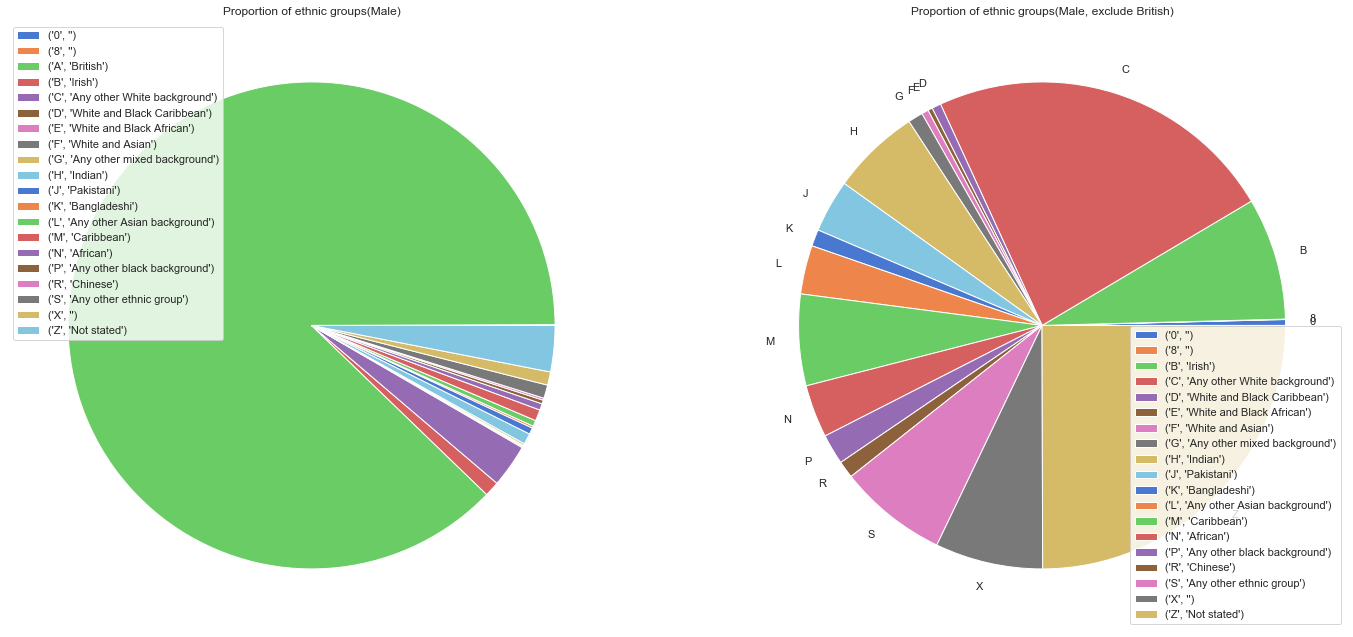

In [15]:
# Visualise the proportion in two pie charts
fig1, ax1 = plt.subplots(1, 2, figsize=(24, 24))
ax1[0].pie(m_ethnicity, textprops={'fontsize': 8})
ax1[1].pie(m_non_british, labels= [x[0] for x in m_non_british_labels])
ax1[0].set_title('Proportion of ethnic groups(Male)')
ax1[1].set_title('Proportion of ethnic groups(Male, exclude British)')
ax1[0].legend(m_labels)
ax1[1].legend(m_non_british_labels)

plt.show()

In [16]:
# The proportion of ethnic groups among female patients
fm_ethnicity = group_a['PATIENTID'][20:40]
fm_ethnicity_codes = [x[1] for x in fm_ethnicity.index]
fm_labels = list(zip(fm_ethnicity_codes, ethnicity_names))

# The proportion of ethnic groups among non-british female patients
fm_non_british = fm_ethnicity.drop(labels=(2, 'A'))
fm_non_british_labels = list(zip(fm_ethnicity_codes, ethnicity_names))
fm_non_british_labels.remove(('A', 'British'))

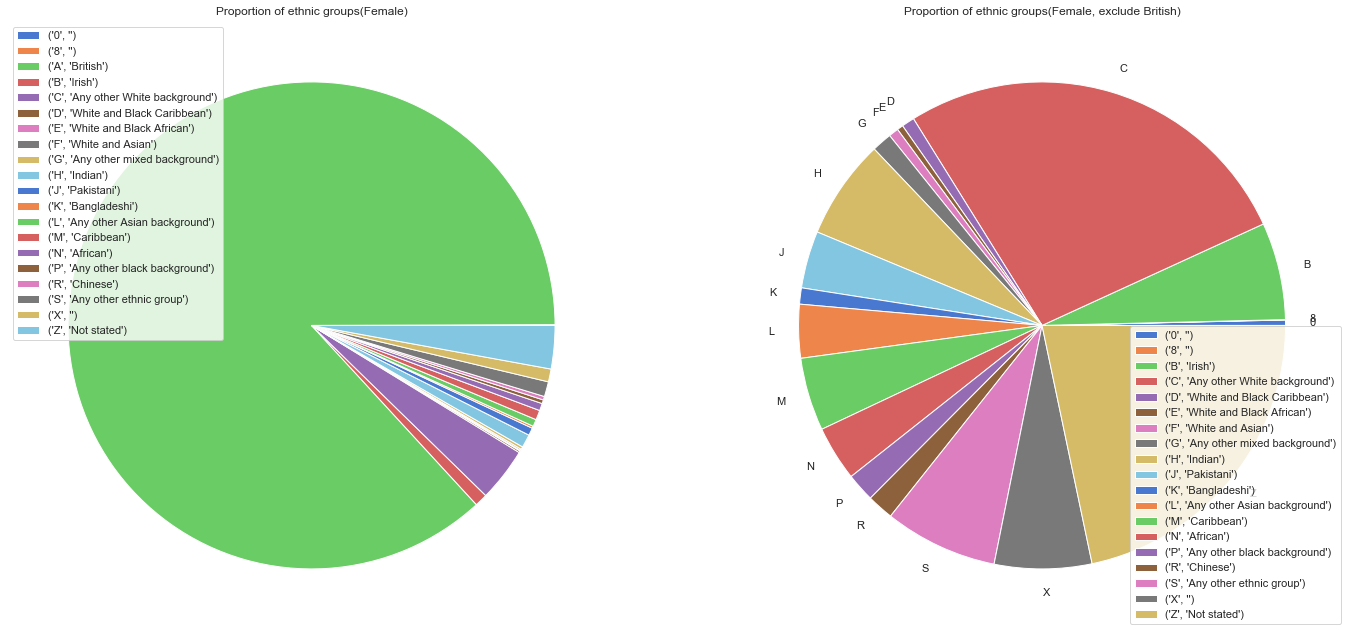

In [17]:
# Visualise the proportion in two pie charts
fig2, ax2 = plt.subplots(1, 2, figsize=(24, 24))
ax2[0].pie(fm_ethnicity)
ax2[1].pie(fm_non_british, labels=[x[0] for x in fm_non_british_labels])
ax2[0].set_title('Proportion of ethnic groups(Female)')
ax2[1].set_title('Proportion of ethnic groups(Female, exclude British)')
ax2[0].legend(fm_labels)
ax2[1].legend(fm_non_british_labels)

plt.show()

In [18]:
group_b = patient.groupby('DEATHCAUSECODE_1A').count()
# group_b
# group_b['PATIENTID'].plot()



In [19]:
patient['DEATHLOCATIONCODE'].value_counts().sum()

330347

## VITAL STATUS

In [20]:
vital_status = patient.groupby('NEWVITALSTATUS').count()
patients_alive = vital_status.iloc[vital_status.index.get_level_values('NEWVITALSTATUS') == 'A'].sum().max()
patients_deceased = vital_status.iloc[vital_status.index.get_level_values('NEWVITALSTATUS') == 'D'].sum().max()

proportion_of_death = patients_deceased / (patients_deceased + patients_alive)

# proportion_of_death.format
# vital_status

### Death Location

In [21]:
patient['DEATHLOCATIONCODE'].value_counts()

1    138309
4     98679
2     40280
X     28206
5     17018
6      7146
3       709
Name: DEATHLOCATIONCODE, dtype: int64

### Death Causes

142,407 patients died because of bronchus or lung 

In [22]:
death_causes = {} # Init a dict to store all the death cause codes and how many times.

# Define a function to split multiple codes and calculate the numbers of each code.
def calculate_death_causes(code):
    if type(code) == str:
        for i in code.split(','):
            if i.strip() not in death_causes and i != '':
                death_causes[i.strip()] = 1  # If the death code is not in the dict, put it in and set its number to 1.
            elif i != '':
                death_causes[i.strip()] += 1 # Otherwise, add 1 to its number.
    else:
        pass

# Apply this function to all the death cause code columns.
patient['DEATHCAUSECODE_1A'].map(calculate_death_causes)
patient['DEATHCAUSECODE_1B'].map(calculate_death_causes)
patient['DEATHCAUSECODE_1C'].map(calculate_death_causes)
patient['DEATHCAUSECODE_2'].map(calculate_death_causes)
patient['DEATHCAUSECODE_UNDERLYING'].map(calculate_death_causes)

# Turn the dict into a Pandas Series Object.
death_causes_series = pd.Series(death_causes)

print(death_causes_series.idxmax(), death_causes_series.max())
print(death_causes_series.idxmin(), death_causes_series.min())

C349 142428
G904 1


In [23]:
classified_death_codes = {}

for k, v in death_causes.items():
    if k[0] not in classified_death_codes.keys():
        classified_death_codes[k[0]] = {}

for k, v in death_causes.items():
    if k[0] in classified_death_codes.keys():
        if k[0:3] not in classified_death_codes[k[0]]:
            classified_death_codes[k[0]][k[0:3]] = v
        elif k[0:3] in classified_death_codes[k[0]]:
            classified_death_codes[k[0]][k[0:3]] += v

multiindex = [[],[]]
death_causes_times = []

for k, v in {(i, j): classified_death_codes[i][j] for i in classified_death_codes.keys() for j in classified_death_codes[i].keys()}.items():
    multiindex[0].append(k[0])
    multiindex[1].append(k[1])
    death_causes_times.append(v)

death_causes_table = pd.DataFrame(death_causes_times, index=multiindex, columns=['times'])

## Reference
[Ethnicity Category Code](https://www.datadictionary.nhs.uk/data_dictionary/attributes/e/end/ethnic_category_code_de.asp)

In [24]:
# patient.describe()
# patient['DEATHCAUSECODE_1A'][]



## Merge
The table of patients registered is linked to the table of tumours registered by `PATIENTID`. I merged the two tables into `merged_av_data` to scrutinise the data.

In [25]:
# Merge the two tables on 'PATIENTID' column and in 'inner' way.
merged_av_data = tumour.merge(patient, on='PATIENTID', how='inner')
merged_av_data.head()

,TUMOURID,PATIENTID,DIAGNOSISDATEBEST,SITE_ICD10_O2,SITE_ICD10_O2_3CHAR,MORPH_ICD10_O2,BEHAVIOUR_ICD10_O2,T_BEST,N_BEST,M_BEST,...,LINK_NUMBER,ETHNICITY,DEATHCAUSECODE_1A,DEATHCAUSECODE_1B,DEATHCAUSECODE_1C,DEATHCAUSECODE_2,DEATHCAUSECODE_UNDERLYING,DEATHLOCATIONCODE,NEWVITALSTATUS,VITALSTATUSDATE
0,10000001,10000001,2015-11-06,C443,C44,8090,3,NaN,NaN,NaN,...,810000001,A,NaN,NaN,NaN,NaN,NaN,NaN,A,2017-01-17
1,10000002,10000002,2015-10-06,C449,C44,8090,3,NaN,NaN,NaN,...,810000002,Z,NaN,NaN,NaN,NaN,NaN,NaN,A,2017-01-14
2,10000003,10000003,2013-01-30,C449,C44,8090,3,NaN,NaN,NaN,...,810000003,A,NaN,NaN,NaN,NaN,NaN,NaN,A,2017-01-17
3,10000004,10000004,2015-09-15,C449,C44,8090,3,NaN,NaN,NaN,...,810000004,A,NaN,NaN,NaN,NaN,NaN,NaN,A,2017-01-13
4,10000005,10000005,2014-11-01,C449,C44,8090,3,NaN,NaN,NaN,...,810000005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A,2017-01-16


In [26]:
# Set the 'PATIENTID' and 'TUMOURID' columns as the index because one patient can get manifold cancers.
merged_av_data.set_index(['PATIENTID', 'TUMOURID'], inplace=True)

In [27]:
# merged_av_data['T_BEST'].value_counts()
merged_av_data.fillna('', inplace=True)


Text(0.5, 1.0, 'Age Distribution')

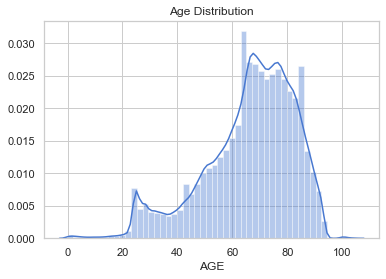

In [28]:
# merged_av_data['AGE']
ax = sns.distplot(merged_av_data['AGE'])
ax.set_title('Age Distribution')

In [79]:
# bins = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110]
# cats = pd.cut(merged_av_data['AGE'], bins)

# age_group = [str(x.left) + ', ' + str(x.right) for x in cats]
# merged_av_data['Age Group'] = cats
# merged_av_data['Age Group'][0]

def calculate_death_rate(group):
    g = merged_av_data.loc[(merged_av_data['AGE'] > group[0]) & (merged_av_data['AGE'] <= group[1]), :].groupby('NEWVITALSTATUS').count()
    death_rate = g.iloc[g.index.get_level_values('NEWVITALSTATUS') == 'D'].sum().max() / merged_av_data.loc[(merged_av_data['AGE'] > group[0]) & (merged_av_data['AGE'] <= group[1]), :].shape[0]
    return death_rate

age_groups = np.array([[x*10, (x+1)*10] for x in range(11)])

death_rate_by_age_group = pd.DataFrame(data={'AGE GROUP': [str(group) for group in age_groups], 'DEATH RATE': [calculate_death_rate(group) for group in age_groups]})

Text(0.5, 1.0, 'Death Rate by Age Group')

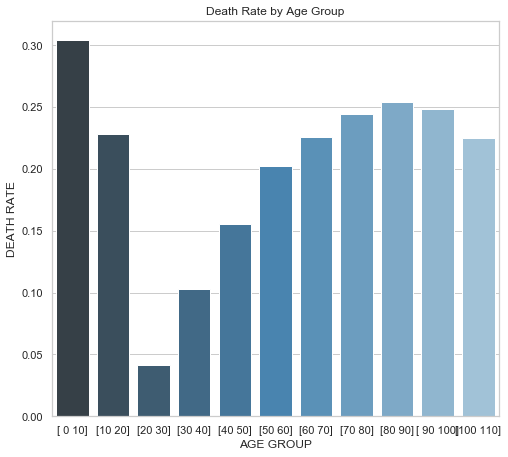

In [80]:
p1 = plt.figure(figsize=(8,16),dpi=72)
ax_death_by_age = p1.add_subplot(2,1,1)
ax_death_by_age = sns.barplot(x='AGE GROUP', y='DEATH RATE', data=death_rate_by_age_group, palette='Blues_d', orient='H')
ax_death_by_age.set_title('Death Rate by Age Group')

## Type of cancer

In [31]:
def match_neoplasms_3CHAR(site_code_3CHAR):
    if site_code_3CHAR != "":
        return icd_codes_3char.loc[icd_codes_3char['Code'] == [re.search(site_code_3CHAR, icd_code).string for icd_code in icd_codes_3char['Code'].values if re.search(site_code_3CHAR, icd_code) != None][0], 'Description'].values[0]
    
def death_rate_by_site_3char(site_code_3char):
    if site_code_3char != "":
        g = merged_av_data[merged_av_data['SITE_ICD10_O2_3CHAR'] == site_code_3char].groupby('NEWVITALSTATUS').count()
        death_rate = g.iloc[g.index.get_level_values('NEWVITALSTATUS') == 'D'].sum().max() / g.iloc[:, :].sum().max()
        return death_rate

types_of_cancer_3char = pd.DataFrame({
    'Code': merged_av_data['SITE_ICD10_O2_3CHAR'].value_counts().index,
    'Description': [match_neoplasms_3CHAR(x) for x in list(merged_av_data['SITE_ICD10_O2_3CHAR'].value_counts().index.to_numpy())],
    'Amount': merged_av_data['SITE_ICD10_O2_3CHAR'].value_counts().values,
    'Death Rate': [death_rate_by_site_3char(x) for x in list(merged_av_data['SITE_ICD10_O2_3CHAR'].value_counts().index.to_numpy())]
})

types_of_cancer_3char.sort_values('Code')

,Code,Description,Amount,Death Rate
91,,None,461,NaN
82,C00,Malignant neoplasm of lip,662,0.120846
52,C01,Malignant neoplasm of base of tongue,2383,0.234578
44,C02,Malignant neoplasm of other and unspecified pa...,3655,0.268673
68,C03,Malignant neoplasm of gum,1084,0.298893
66,C04,Malignant neoplasm of floor of mouth,1372,0.285714
69,C05,Malignant neoplasm of palate,1055,0.199052
62,C06,Malignant neoplasm of other and unspecified pa...,1591,0.318039
67,C07,Malignant neoplasm of parotid gland,1287,0.164724
99,C08,Malignant neoplasm of other and unspecified ma...,309,0.216828


In [32]:


    
# def calculate_death_rate(group):
#     g = merged_av_data.loc[(merged_av_data['AGE'] > group[0]) & (merged_av_data['AGE'] <= group[1]), :].groupby('NEWVITALSTATUS').count()
#     death_rate = g.iloc[g.index.get_level_values('NEWVITALSTATUS') == 'D'].sum().max() / merged_av_data.loc[(merged_av_data['AGE'] > group[0]) & (merged_av_data['AGE'] <= group[1]), :].shape[0]
#     return death_rate

# g.iloc[g.index.get_level_values('NEWVITALSTATUS') == 'D'].sum().max()
# g['NEWVITALSTATUS']

### TNM Staging

In [33]:
# def convert_staging(stages):
#     for stage in stages:
#     filter(str.isdigit, )

# merged_av_data['T_BEST'].value_counts()
merged_av_data['T_BEST']



# # merged_av_data[['T_BEST', 'N_BEST', 'M_BEST']] = merged_av_data[['T_BEST', 'N_BEST', 'M_BEST']].astype(str)
# # merged_av_data['M_BEST'].value_counts().index
# # merged_av_data[(merged_av_data['M_BEST'] != '0' and merged_av_data['M_BEST'] != str(0.0))]
# # type(merged_av_data.iloc[merged_av_data.index.get_level_values('PATIENTID') == 10000018]['M_BEST'][0])

PATIENTID  TUMOURID 
10000001   10000001       
10000002   10000002       
10000003   10000003       
10000004   10000004       
10000005   10000005       
                        ..
220039666  220051512     1
220044010  220051679      
220045545  220051740      
220046812  220051825      
220048063  220051877    1a
Name: T_BEST, Length: 1402749, dtype: object

In [34]:
# tumour[tumour['PATIENTID' == 210004664]]
tumour['PATIENTID'].value_counts()
tumour[tumour['PATIENTID'] == 60035351]

,TUMOURID,PATIENTID,DIAGNOSISDATEBEST,SITE_ICD10_O2,SITE_ICD10_O2_3CHAR,MORPH_ICD10_O2,BEHAVIOUR_ICD10_O2,T_BEST,N_BEST,M_BEST,...,PERFORMANCESTATUS,CNS,ACE27,GLEASON_PRIMARY,GLEASON_SECONDARY,GLEASON_TERTIARY,GLEASON_COMBINED,DATE_FIRST_SURGERY,LATERALITY,QUINTILE_2015
816073,60035351,60035351,2013-07-22,C183,C18,8140,3,NaN,NaN,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-07-22,8,4
845745,60066711,60035351,2013-07-22,C20,C45,8070,3,NaN,NaN,NaN,...,0,Y2,0,NaN,NaN,NaN,NaN,2013-07-22,8,4
847728,60068814,60035351,2013-07-22,C187,C18,8140,3,1,2,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,4
847878,60069008,60035351,2013-07-22,C19,C18,8210,3,3a,0,0,...,NaN,99,NaN,NaN,NaN,NaN,NaN,2013-07-22,8,4
847891,60069026,60035351,2013-08-20,D010,C18,8140,3,2,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-08-20,8,4
847892,60069028,60035351,2014-03-09,C509,C64,8130,3,1b,0,0,...,3,NaN,NaN,NaN,NaN,NaN,NaN,2014-05-09,L,4


In [35]:
# tumour_reindex.iloc[tumour_reindex.index.get_level_values('PATIENTID') == 60035351]

In [36]:
# tumour.groupby('SITE_ICD10_O2').count()

In [37]:
patient.shape

(1322035, 12)

In [38]:
tumour.shape

(1402817, 34)

In [39]:
merged_av_data.shape

(1402749, 43)

In [40]:
len(merged_av_data.index)

1402749

In [41]:
# merged_av_data = merged_av_data.set_index(['PATIENTID', 'TUMOURID'])

KeyError: "None of ['PATIENTID', 'TUMOURID'] are in the columns"

In [ ]:
# merged_av_data.iloc[merged_av_data.index.get_level_values('PATIENTID') == 60035351][['AGE', 'DIAGNOSISDATEBEST']]

In [ ]:
merged_av_data.shape

In [ ]:
tumour.shape

In [ ]:
merged_av_data.head()

In [ ]:
merged_av_data['DATE_FIRST_SURGERY'] = pd.to_datetime(merged_av_data['DATE_FIRST_SURGERY'])
merged_av_data['DIAGNOSISDATEBEST'] = pd.to_datetime(merged_av_data['DIAGNOSISDATEBEST'])

# (merged_av_data['DATE_FIRST_SURGERY'] - merged_av_data['DIAGNOSISDATEBEST']).value_counts() < pd.Timedelta('0 days 00:00:00')

In [ ]:
merged_av_data['DATE_FIRST_SURGERY']
merged_av_data['DIAGNOSISDATEBEST']

In [67]:
# merged_av_data.groupby(['SEX_y', 'NEWVITALSTATUS']).count().iloc
merged_av_data['M_BEST'].value_counts()

       867097
0      396681
1       80765
1b      36196
1a      14767
0.0      6388
1c        574
X         236
1.0        42
2           2
1e          1
Name: M_BEST, dtype: int64

In [78]:
merged_av_data[(merged_av_data['M_BEST'] != 0.0) & (merged_av_data['M_BEST'] != '0') & (merged_av_data['M_BEST'] != '')].groupby('NEWVITALSTATUS').count().iloc[1][0]

86167